In [ ]:
from google.colab import drive
drive.mount('/content/drive')
% cd drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as sch
import matplotlib.pyplot as plt
import pickle

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, image_folder, column_label, image_height, image_width):
        assert Path(csv_path).exists()
        assert Path(csv_path).is_file()
        
        assert Path(image_folder).exists() 
        assert Path(image_folder).is_dir()
        
        
        self.df = pd.read_csv(csv_path)
        self.image_folder = Path(image_folder)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((image_height, image_width)),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.3)
        ])
        
        assert column_label in self.df.columns
        self.column_label = column_label
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index]['Id'] + '.jpg'
        image_path = self.image_folder.joinpath(filename)
        image = self.transform(Image.open(image_path))
        
        label = self.df.loc[index][self.column_label]
        
        return image, label

In [ ]:
def build_datasets(csv_path='petfinder_data/train.csv', image_path='petfinder_data/train/', response='Pawpularity', 
                   image_height=64, image_width=64, train_split=0.8, batch_size=32, num_workers=3):
  pawpularity_dataset = CustomDataset('petfinder_data/train.csv', 'petfinder_data/train/', response, image_height, image_width)
  train_size = int(len(pawpularity_dataset) * train_split)
  test_size = len(pawpularity_dataset) - train_size
  paw_train_data, paw_test_data = torch.utils.data.random_split(pawpularity_dataset, [train_size, test_size])
  train_data = torch.utils.data.DataLoader(paw_train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
  test_data = torch.utils.data.DataLoader(paw_test_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
  return train_data, test_data

In [ ]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def build_model(pretrained=True, update_weights=False):
  # import efficient net
  efficient_net = models.efficientnet_b3(pretrained=pretrained).to(device)

  # don't update on model parameters
  if not update_weights:
    for param in efficient_net.parameters():
        param.requires_grad = False

  # replace model classifier to fit our data
  efficient_net.classifier[1] = nn.Sequential(nn.Sequential(
                      nn.Linear(1536, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.2),
                      nn.Linear(256, 1)).to(device))
  
  return efficient_net

In [ ]:
def train_model(model, train_data, test_data, device=device, epochs=10, lr=0.005):
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr)
  scheduler = sch.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
  avg_train_loss, avg_test_loss = [], []

  for epoch in range(epochs):
      
      train_loss, test_loss = 0, 0 

      i = 0
      for inputs, labels in train_data:
          inputs = inputs.to(device)
          labels = labels.reshape(len(labels), 1).to(device)
          
          
          # zero out gradients
          optimizer.zero_grad()
      
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          train_loss += loss
          loss.backward()
          optimizer.step()
          
          if i % 40 == 0:
            print('Epoch: {:<3d} \t Batch: {:>3d}/{:<3d}  \t Avg Train Loss: {:>3.2f}'.format(epoch, i, len(train_data), train_loss/(i+1)))
          i += 1

      v = 0
      for test_inputs, test_labels in test_data:
          test_inputs = test_inputs.to(device)
          test_labels = test_labels.reshape(len(test_labels), 1).to(device)
          
          with torch.no_grad():
              test_out = model(test_inputs)
              tloss = criterion(test_out, test_labels)
              test_loss += tloss
                
          if v % 40 == 0:
            print('Epoch: {:<3d} \t Batch: {:>3d}/{:<3d} \t Avg Test Loss: {:>3.2f}'.format(epoch, v, len(test_data), test_loss/(v+1)))
            for j in range(10):
              print('Prediction: {} \t Label: {}'.format(test_out[j].item(), test_labels[j].item()))

          v += 1

      avg_train_loss.append(train_loss / len(train_data))
      avg_test_loss.append(test_loss / len(test_data))
      scheduler.step(test_loss)
  return model, avg_train_loss, avg_test_loss

In [ ]:
def run(epochs, bs, lr, pretrained=True, update_weights=False):
  train_data, test_data = build_datasets(batch_size=bs)
  efficient_net = build_model(pretrained, update_weights)
  model, avg_train_loss, avg_test_loss = train_model(efficient_net, train_data, test_data, epochs=epochs, lr=lr)
  print('Final Train Loss: {} \t Final Test Loss: {}'.format(avg_train_loss[-1], avg_test_loss[-1]))
  return model, avg_train_loss, avg_test_loss

In [ ]:
# for hyperparameter tuning
epochs = 15
batch_size = 32
learning_rates = [0.01, 0.005, 0.001, 0.0005]
avg_train_loss_by_run, avg_test_loss_by_run = [], []

for lr in learning_rates:
  print('\nRunning model with {} learning rate...'.format(lr))
  _, train_loss, test_loss = run(epochs=epochs, bs=batch_size, lr=lr)
  avg_train_loss_by_run.append(train_loss)
  avg_test_loss_by_run.append(test_loss)

In [ ]:
for i in range(len(avg_test_loss_by_run)):
  print('Learning Rate: {} \t Min Test Loss: {}'.format(learning_rates[i], avg_test_loss[i][-1].item()))

Learning Rate: 0.0075 	 Min Test Loss: 15.638766288757324
Learning Rate: 0.005 	 Min Test Loss: 15.244185447692871
Learning Rate: 0.0025 	 Min Test Loss: 15.843419075012207


In [ ]:
model, avg_train_loss, avg_test_loss = run(epochs=15, bs=32, lr=0.005, pretrained=False, update_weights=True)

In [ ]:
avg_train_loss

[tensor(0.1099, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1325, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1240, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1361, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1416, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1423, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1304, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1421, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1425, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1475, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/'
save_name = 'pawpularity_model'

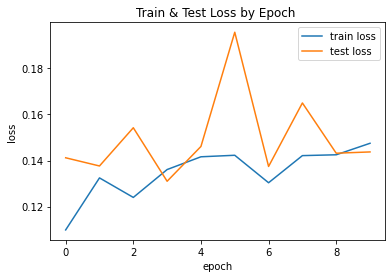

In [ ]:
ep = np.arange(epochs)

plt.plot(ep, torch.stack(avg_train_loss).cpu().detach().numpy(), label='train loss')
plt.plot(ep, torch.stack(avg_test_loss).cpu().detach().numpy(), label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train & Test Loss by Epoch ')
plt.legend()
plt.savefig(save_path + save_name)

In [ ]:
# pickle.dump(efficient_net, open(save_path + save_name + '.sav', 'wb'))
torch.save(model, save_path + save_name)